In [ ]:
from utilities.constants import *
from utilities.temporal_analysis import *
import matplotlib.pyplot as plt
from utilities.model_matching_computation import *
from utilities.features_eng import *
import pandas as pd
from music21 import *
from utilities.corpus_search import *
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV


le = LabelEncoder()
df_notes = pd.read_json('note_corpus3.json', orient ='split', compression = 'infer')
#df_notes = get_timestamps_from_all_corpus()
df_notes['tie'] = df_notes['tie'].fillna(-1)

df_notes = df_notes.dropna()
df_notes['NoteAndRest'] = df_notes['NoteAndRest'].apply(lambda x: re.sub(r'\d+', '', x))
df_notes['quarterLength'] = [0.33 if i == '1/3' else i for i in df_notes['quarterLength']]
df_notes['offset'] = [8/3 if i == '8/3' else i for i in df_notes['offset']]
df_notes['offset'] = [7/3 if i == '7/3' else i for i in df_notes['offset']]

df_notes = label_length(df_notes)
keys_to_encode = df_notes['key'].apply(lambda x: str(x)).tolist()
df_notes['key'] =  le.fit_transform(keys_to_encode)
df_notes = df_notes[df_notes['length_section'] > 30]


/tmp/ipykernel_1148/4220467024.py:38: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all = pd.concat([temp, all])
/tmp/ipykernel_1148/4220467024.py:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pitch_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(compute_avg_folded_hist_labeled_notes(x['NoteAndRest'].tolist(), x['quarterLength'].tolist())))
/tmp/ipykernel_1148/4220467024.py:52: DeprecationWarning: DataFrameGroupBy.apply ope

Counter({16.0: 18, 1.0: 17, 14.0: 15, 2.0: 14, 9.0: 12, 18.0: 11, 3.0: 10, 5.0: 9, 10.0: 7})
Minimum class count: 7
1 17
2 14
3 10
5 9
9 12
10 7
14 15
16 18
18 11
[[64 0.5 588.92 ... 1.0 0.125 1.0]
 [67 0.5 630.46 ... 6.0 0.25 1.0]
 [60 0.5 404.77 ... 1.5 0.0625 1.0]
 ...
 [67 1.5 787.38 ... 0.0 1.0 1.0]
 [62 0.5 370.15 ... 4.0 0.5 1.0]
 [62 0.5 458.77 ... 4.0 0.5 1.0]]
[[64 0.5 588.92 ... 1.0 0.125 1.0]
 [67 0.5 630.46 ... 6.0 0.25 1.0]
 [60 0.5 404.77 ... 1.5 0.0625 1.0]
 ...
 [67 1.5 787.38 ... 0.0 1.0 1.0]
 [62 0.5 370.15 ... 4.0 0.5 1.0]
 [62 0.5 458.77 ... 4.0 0.5 1.0]]
[[65 0.5 1382.77 ... 5.0 0.125 1.0]
 [71 1.0 1520.08 ... 4.0 0.5 1.0]
 [65 0.25 1197.46 ... 4.25 0.0625 1.0]
 ...
 [67 1.5 994.15 ... 0.0 1.0 1.0]
 [69 0.5 1509.23 ... 6.0 0.25 1.0]
 [60 0.5 1356.0 ... 0.0 1.0 1.0]]
[[65 0.5 1382.77 ... 5.0 0.125 1.0]
 [71 1.0 1520.08 ... 4.0 0.5 1.0]
 [65 0.25 1197.46 ... 4.25 0.0625 1.0]
 ...
 [67 1.5 994.15 ... 0.0 1.0 1.0]
 [69 0.5 1509.23 ... 6.0 0.25 1.0]
 [60 0.5 1356.0 ...

array([0.        , 0.02790795, 0.02370724, 0.01963907, 0.0182826 ,
       0.02092848, 0.01947719, 0.01827345, 0.01888877, 0.01980633,
       0.01041601, 0.01351562, 0.01635137, 0.00796885, 0.01586011,
       0.03277201, 0.00014986, 0.07416159, 0.02374582, 0.06743569,
       0.0550194 , 0.06766799, 0.02973568, 0.        , 0.04475187,
       0.03640264, 0.05818228, 0.00041324, 0.01912171, 0.01845527,
       0.02100528, 0.02430382, 0.        , 0.01567931, 0.0110204 ,
       0.00342299, 0.00319147, 0.02708033, 0.01703612, 0.09822222])

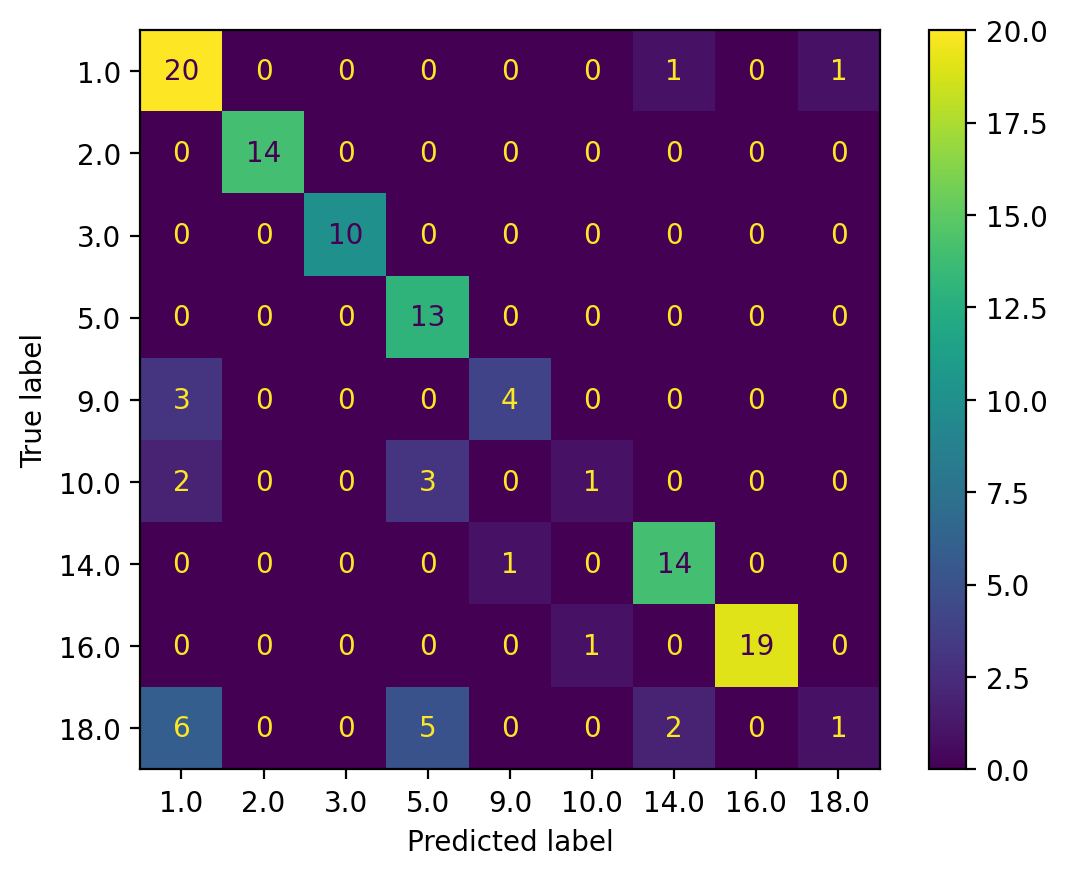

In [17]:
label = 'tab'
length_param = [256, 512, 1024]
stride_param = [True, False]
random_state = 42
# Function to convert note and octave to MIDI number
def note_to_midi(note):
    note_name = note[0:]  # Extract the note name (e.g., 'A', 'B', etc.)
    #octave = int(note[-1])  # Extract the octave (e.g., '0', '2', etc.)
    octave = 4  # Extract the octave (e.g., '0', '2', etc.)
    if 'Rest' in note_name: return -1
    return NOTE_TO_MIDI[note_name] + 12 * (octave + 1)
def return_windowed_df(df, columns, label, skip1 = False, apply_stride = False, length_sequence = 1024):
    grouped = df.groupby("section_id", group_keys=True)[columns]
    stride = length_sequence / 2 if apply_stride else length_sequence
    stride = int(stride)
    all = pd.DataFrame(columns=columns)
    if columns[:-1] == 'mizan':
        
        skip1 = True
    for section_id, group in grouped:
        
        l = 0
        r = length_sequence
        temp = pd.DataFrame(columns=columns)
        
        if skip1 and [x[10] for x in group.values[l:r]][0] == 1:
            for i, c in enumerate(columns):
                temp[c] = [x[i] for x in group.values[:]]
            temp['section_id'] = [section_id + str(l)] * len(temp) 
            all = pd.concat([temp, all])
            continue
        
        while(len(group.values[l:r]) >= length_sequence):
            for i, c in enumerate(columns):
                temp[c] = [x[i] for x in group.values[l:r]]
              
            temp['section_id'] = [section_id + str(l)] * stride *2 if apply_stride else [section_id + str(l)] * stride
            all = pd.concat([temp, all])
            l += stride
            r += stride  
    return all


df_windowed = return_windowed_df(df_notes, ['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', 'tie', 'nawba', 'mizan', 'tab'], label, apply_stride=True, length_sequence=1024)
# Create new dataset with translated notes to pitch
df_midi = df_windowed.copy()

df_midi = df_midi[df_midi['length_section'] > 30]
df_midi['NoteAndRest'] = df_midi['NoteAndRest'].apply(lambda x: note_to_midi(x))
df = df_midi[df_midi[label].isin(LABEL_LIST_TRAIN[label])]
pitch_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(compute_avg_folded_hist_labeled_notes(x['NoteAndRest'].tolist(), x['quarterLength'].tolist())))
ql_distr_sections = df_windowed.groupby('section_id').apply(lambda x: list(get_folded_rhythm_histogram(x['quarterLength'].tolist())))
len(df_midi['section_id'].unique())
# Define the length of prefix to group by
prefix_length = len('f461045b-50bc-4b20-a731-66fbd3a264ae')
assert len(df['section_id'].unique()) == len(set(df['section_id'].unique())), "There are duplicates in the original ID list!"

# Step 1: Group all IDs by their prefix
from collections import defaultdict

to_stratify = []
prefix_to_ids = defaultdict(list)
prev_pref = ""
for id_ in df['section_id'].unique():
    prefix = id_[:prefix_length]
    prefix_to_ids[prefix].append(id_)
    if prev_pref != prefix:
       
        to_stratify.append(df.loc[df['section_id'].str.contains(id_)][label][0].tolist())
        prev_pref = prefix
prefixes = list(prefix_to_ids.keys())
from collections import Counter

label_counts = Counter(to_stratify)
print(label_counts)
print("Minimum class count:", min(label_counts.values()))
for y in LABEL_LIST_TRAIN[label]:
    print(y, len([x for x in to_stratify if x == y]))

train_prefixes, test_prefixes = train_test_split(prefixes, stratify=to_stratify, test_size=0.2, random_state=random_state)

# Step 3: Gather IDs for train and test sets
train_ids = [id_ for prefix in train_prefixes for id_ in prefix_to_ids[prefix]]
test_ids = [id_ for prefix in test_prefixes for id_ in prefix_to_ids[prefix]]


def compare_plot_label_distribution(df_windowed, df_notes):
    def return_label_distributions(df):
        distributions = {
            'nawba' : [],
            'tab' : [],
            'mizan' : []
        }
        for l2 in ['nawba', 'tab', 'mizan']:
            
            for l in LABEL_LIST_TRAIN[l2]:
                
                distributions[l2].append(len(df[df[l2] == l]['section_id'].unique()))
        return distributions
    fig = plt.figure(figsize=(20, 4))
    for i, l2 in enumerate(['nawba', 'tab', 'mizan']):
        plt.subplot(1, 3, i+1)
        plt.bar(LABEL_LIST_TRAIN[l2], (return_label_distributions(df_windowed)[l2]), alpha = 0.8, label = 'New Sections')
        plt.bar(LABEL_LIST_TRAIN[l2], (return_label_distributions(df_notes)[l2]), alpha = 0.8, label = 'Original')
    plt.tight_layout()
    plt.legend()
#compare_plot_label_distribution(df_windowed, df_notes)
shuffled_df = df.sample(frac=1, random_state=random_state)

# Group by 'section_id'
grouped = shuffled_df.groupby("section_id", group_keys=True)[['NoteAndRest', 'quarterLength', 'timestamp_(scs)', 'length_section', 'bpm', 'key', 'offset', 'beatStrength', label]]
# Create an array for each group

group_arrays = {section_id: group.values for section_id, group in grouped}

    
avg_sequence_length = 0
sequences_features = []
X_train = []
y_train = []
X_test = []
y_test = []

for key, values in group_arrays.items():
    
    if key in train_ids:
        X_train.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
        y_train.append((values[0][-1]))
    else:
        X_test.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))
        y_test.append((values[0][-1]))

    sequences_features.append(extract_feature(values, pitch_distr_sections[key], ql_distr_sections[key]))

    avg_sequence_length += len(values) 

sequences_features = [list(x.values()) for x in sequences_features]
X_train = [list(x.values()) for x in X_train]
X_test = [list(x.values()) for x in X_test]

"""
num_train = []
num_test = []
for y in LABEL_LIST_TRAIN[label]:
    num_train.append(len([x for x in y_train if x == y]))
    num_test.append(len([x for x in y_test if x == y]))
plt.bar(LABEL_LIST_TRAIN[label], num_train, label ="Train")
plt.bar(LABEL_LIST_TRAIN[label], num_test, label ="Test")
"""

"""
# Your features and labels
X = sequences_features
y = list(df.groupby("section_id", group_keys=True)[label].first())  
for m in LABEL_LIST_TRAIN[label]:
    print(m, len([x for x in y if x == m]))  
"""
"""
clf = RandomForestClassifier()
# Initialization of hyperparameter choice
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['sqrt', 'log2', None]
criterion = ['gini', 'entropy', 'log_loss']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion': criterion,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

rf_random = RandomizedSearchCV(estimator = clf, param_distributions = random_grid, n_iter = 20, cv = 10, verbose=2, random_state=random_state2, n_jobs = -1)
rf_random.fit(X_train, y_train)
rf_random.best_params_
"""
"""
# Your features and labels
X = sequences_features
y = list(df.groupby("section_id", group_keys=True)[label].first())    
# For Mizan
clf = RandomForestClassifier(n_estimators=600, random_state=random_state, min_samples_split=5, min_samples_leaf=2, max_features=None, max_depth=70,  bootstrap=True, criterion='log_loss')
# For Nawba
#clf = RandomForestClassifier(n_estimators=200, random_state=random_state, min_samples_split=10, min_samples_leaf=1, max_features='log2', max_depth=30,  bootstrap=False, criterion='log_loss')
# For Tab

cv_scores = cross_val_score(clf, X, y, cv= 50)
# Print individual scores and average
print("Cross-validation scores:", cv_scores)
print("Mean CV accuracy:", cv_scores.mean())

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size= 0.2, random_state=random_state)"""
clf = RandomForestClassifier(n_estimators=800, random_state=random_state, min_samples_split=2, min_samples_leaf=1, max_features='log2', max_depth = None, bootstrap=False, criterion='entropy')
clf.fit(X_train, y_train)
clf.predict(X_test)
#print_performance(y_test, clf.predict(X_test), cv_scores)
print_performance(y_test, clf.predict(X_test))
clf.feature_importances_
